# 試しにMnistの分類モデルを作る

In [1]:
%matplotlib inline

In [2]:
import copy
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

root = "./data"

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

batch_size = 128

trainset = datasets.MNIST(root=root, download=True, train=True, transform=transform)
testset = datasets.MNIST(root=root, download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

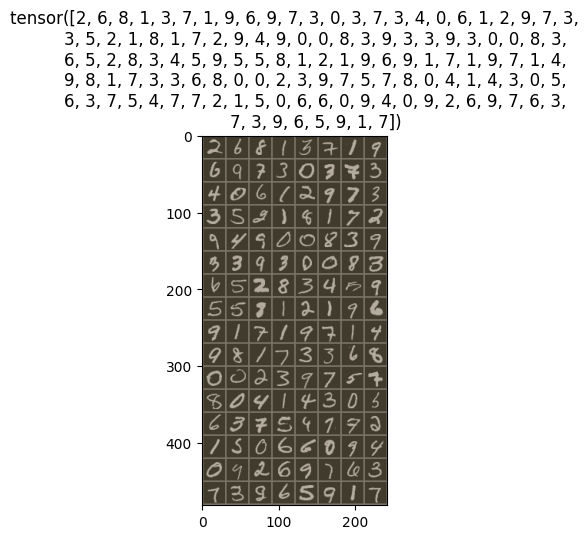

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # プロット図が更新されるように少しだけ一時停止


# 訓練データのバッチを取得する
inputs, classes = next(iter(trainloader))

# バッチからグリッドを作成する
out = torchvision.utils.make_grid(inputs)

imshow(out, title=classes)

In [4]:
def train_model(model, criterion, optimizer, trainloader, testloader, num_epochs=25):
    since = time.time()
    dataloaders = {"train": trainloader, "val": testloader}
    dataset_sizes = {
        "train": len(trainset),
        "val": len(testset),
    }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print("-" * 10)

        # 各エポックには訓練フェーズと検証フェーズがあります
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()  # モデルを訓練モードに設定します
            else:
                model.eval()  # モードを評価するモデルを設定します

            running_loss = 0.0
            running_corrects = 0

            # データをイレテートします
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # パラメータの勾配をゼロにします
                optimizer.zero_grad()

                # 順伝播
                # 訓練の時だけ、履歴を保持します
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 訓練の時だけ逆伝播＋オプティマイズを行います
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # 損失を計算します
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            # if phase == "train":
            #     scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

            # モデルをディープ・コピーします
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(
        "Training complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60
        )
    )
    print("Best val Acc: {:4f}".format(best_acc))

    # ベストモデルの重みをロードします
    model.load_state_dict(best_model_wts)
    return model

In [5]:
class MnistCNN(nn.Module):
    def __init__(self):
        super(MnistCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=0),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=0),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=0),
        )
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Linear(64 * 4 * 4, 100),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(100, 10),
            nn.Dropout(0.5),
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x


model = MnistCNN()

model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    model.parameters(),
)

In [6]:
model_ft = train_model(
    model, criterion, optimizer, trainloader, testloader, num_epochs=25
)

Epoch 0/24
----------
train Loss: 1.2512 Acc: 0.5083
val Loss: 0.0813 Acc: 0.9784

Epoch 1/24
----------
train Loss: 0.9682 Acc: 0.5812
val Loss: 0.0533 Acc: 0.9853

Epoch 2/24
----------
train Loss: 0.9350 Acc: 0.5862
val Loss: 0.0410 Acc: 0.9876

Epoch 3/24
----------
train Loss: 0.9225 Acc: 0.5854
val Loss: 0.0377 Acc: 0.9890

Epoch 4/24
----------
train Loss: 0.9026 Acc: 0.5897
val Loss: 0.0275 Acc: 0.9931

Epoch 5/24
----------
train Loss: 0.8947 Acc: 0.5929
val Loss: 0.0303 Acc: 0.9921

Epoch 6/24
----------
train Loss: 0.8853 Acc: 0.5934
val Loss: 0.0277 Acc: 0.9922

Epoch 7/24
----------
train Loss: 0.8807 Acc: 0.5950
val Loss: 0.0275 Acc: 0.9926

Epoch 8/24
----------
train Loss: 0.8764 Acc: 0.5962
val Loss: 0.0327 Acc: 0.9915

Epoch 9/24
----------
train Loss: 0.8674 Acc: 0.5977
val Loss: 0.0259 Acc: 0.9931

Epoch 10/24
----------
train Loss: 0.8627 Acc: 0.5984
val Loss: 0.0221 Acc: 0.9936

Epoch 11/24
----------
train Loss: 0.8700 Acc: 0.5954
val Loss: 0.0258 Acc: 0.9929

Ep